In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// this makes the jupyter-notebook not generate a scrollbar when the cell is too big 

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


In [14]:
from datetime import datetime, timedelta
# import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

from bokeh.layouts import row as bokeh_row
from bokeh.models import BoxAnnotation, ColumnDataSource, Label, WheelZoomTool, Span
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import output_notebook, export_png

from stevelib import snap_to_roads, haversine_np, convert_gpx_to_df, convert_sumo_to_df, convert_app_logs_to_df, convert_mensa_to_df, convert_data_pipeline_to_df, transform_wgs84_to_web_mercator, plot2, make_circle

output_notebook()

Loading BokehJS ...

In [4]:
# some files are in local time and need to be converted to UTC
# specify here the timezone those files are in
TIMEZONE = 'America/Los_Angeles'

In [5]:
# temporary color map
colors = {
    '248': '#ff0000',
    '248_snap': '#00ffff',
    'JTDKDTB39G1589379': '#0000ff',
    '1G6YV34AX55602068': '#00ff00',
}

## read in different data using specific readers
(sumo, periscope, snap to roads, mensa, gpx, csv, etc.)

In [6]:
# app
df = convert_data_pipeline_to_df('test_data/rawevents_daytona-prod_2019-09-05-21')
df['label'] = 'Luis\' app'

# vehicle CSM
df_temp = convert_sumo_to_df('test_data/search-results-2019-09-05T16_31_20.548-0700.csv')
df_temp['label'] = 'Installed CSM'
df = df.append(df_temp, sort=False)

# CSM on the seat
df_temp = convert_sumo_to_df('test_data/search-results-2019-09-06T10_51_04.919-0700.csv')
df_temp['label'] = 'CSM on the seat'
df = df.append(df_temp, sort=False)

# snap to roads
df_temp = convert_app_logs_to_df('test_data/snap.csv')  # <-- run the snap to roads notebook first to get this csv!
df_temp['label'] = 'Snap to road'
df = df.append(df_temp, sort=False)

# df
df = df.sort_index()
df.head()

,id,lat,long,label,operationCode,operationState,synthesis.isEngineRunning,Unnamed: 0
datetime,,,,,,,,
2019-09-05 20:38:04+00:00,248,37.781891,-122.396586,Luis' app,NaN,NaN,NaN,NaN
2019-09-05 13:44:51.415000-07:00,1G6YV34AX55602068,37.787575,-122.407460,CSM on the seat,SMS,OK,NaN,NaN
2019-09-05 13:44:57.416000-07:00,1G6YV34AX55602068,37.787575,-122.407460,CSM on the seat,NONE,NONE,NaN,NaN
2019-09-05 13:45:05.418000-07:00,1G6YV34AX55602068,37.787575,-122.407460,CSM on the seat,NONE,NONE,NaN,NaN
2019-09-05 13:45:19.424000-07:00,1G6YV34AX55602068,37.787575,-122.407460,CSM on the seat,ENGINE,START,NaN,NaN


## read in reference data using specific readers

In [7]:
# read in the reference csv (in this case exported from Google Sheets)
def convert_csv_to_df(filename, timezone):
    df = pd.read_csv(filename)
    df['departed'] = pd.to_datetime(df['Time departed']).dt.tz_localize(timezone)  # <-- customize this!
    df['arrived'] = pd.to_datetime(df['Time arrived']).dt.tz_localize(timezone)  # <-- customize this!

    df['lat'] = df['lat'].astype(float)
    df['long'] = df['long'].astype(float)
    df['ids'] = df['ids'].str.split(',')  # split the multiple ids into a list
    df = df.drop(columns=['Time departed', 'Time arrived', 'Take pictures'])
    return df#.set_index('datetime').sort_index()

ref = convert_csv_to_df('test_data/Sep 4 experimental iOS app data gathering - Sheet1.csv', TIMEZONE)
ref.head()

,Location,(Description),ids,lat,long,departed,arrived
0,1,clay st,"[1G6YV34AX55602068, 248, 248_snap, JTDKDTB39G1...",37.794838,-122.401063,2019-09-05 14:23:20-07:00,2019-09-05 14:19:13-07:00
1,2,?,"[1G6YV34AX55602068, 248, 248_snap, JTDKDTB39G1...",37.791824,-122.399770,2019-09-05 14:27:32-07:00,2019-09-05 14:25:36-07:00
2,3,campton alley,"[1G6YV34AX55602068, 248, 248_snap, JTDKDTB39G1...",37.789057,-122.406366,2019-09-05 14:34:33-07:00,2019-09-05 14:33:01-07:00
3,4,tow away zone,"[1G6YV34AX55602068, 248, 248_snap, JTDKDTB39G1...",37.796210,-122.397885,2019-09-05 14:43:35-07:00,2019-09-05 14:42:15-07:00


## at each location:

In [16]:
error = []  # temp list holding the id and error 

for index, row in ref.iterrows():
    print(f'Index {index}')
    t_start = row['arrived'] - timedelta(minutes=2)
    t_end = row['departed'] + timedelta(minutes=1)
#     print(t_start, t_end)
#     print(row)

    # draw the basic map
    p = figure(
#         title="Row {} @ {}: {} ({})".format(index+1, row.datetime, row['Inaccuracy Comfort'], row['VIN']),
        plot_width=800, 
        plot_height=800, 
        x_axis_type="mercator", 
        y_axis_type="mercator",
        match_aspect=True,  # make sure the map isn't skewed?
        tools="pan,wheel_zoom,reset")
    p.add_tile(get_provider(Vendors.CARTODBPOSITRON))
    p.toolbar.active_scroll = p.select_one(WheelZoomTool) 
    p.xaxis.axis_label = "Longitude"
    p.yaxis.axis_label = "Latitude"

    
    p2 = figure(
#         title="Row {} @ {}: {} ({})".format(index+1, row.datetime, row['Inaccuracy Comfort'], row['VIN']),
        plot_width=800, 
        plot_height=800, 
        x_axis_type="datetime", 
#                 y_axis_type="mercator",
#                 match_aspect=True,  # make sure the map isn't skewed?
        tools="pan,wheel_zoom,reset")
#             p.add_tile(get_provider(Vendors.CARTODBPOSITRON))
    p2.toolbar.active_scroll = p2.select_one(WheelZoomTool) 
    p2.xaxis.axis_label = "Time"
    p2.yaxis.axis_label = "Error [meters]"

    # plot the reference position
    plot2(p, 
          [row['lat']], 
          [row['long']], 
          color='#000000', 
          size=10, 
#           legend='Reference Position'
         )
    
    # plot the reference rings
    make_circle(p, row['lat'], row['long'], 10, line_width=2, line_color='green', line_alpha=0.25)
    make_circle(p, row['lat'], row['long'], 20, line_width=2, line_color='orange', line_alpha=0.25)
    make_circle(p, row['lat'], row['long'], 30, line_width=2, line_color='red', line_alpha=0.25)
    
    # select the points which belong to this ref location
    for id in row['ids']:
        df_subset = df.loc[df['id'] == id][t_start:t_end]  # the subset for this id and this time frame
        
        if len(df_subset['label']) > 0:  # only do it if there's values
            # plot the points
            plot2(p, 
                  df_subset['lat'].values, 
                  df_subset['long'].values, 
#                   legend=df_subset['label'][0], 
                  color=colors[df_subset['id'][0]],
                  size=5, )
            
            # line graph of the points
            x2, y2 = transform_wgs84_to_web_mercator(df_subset['long'].values, df_subset['lat'].values) 
            source = ColumnDataSource({'x': x2, 'y': y2})
            p.line(x='x', y='y', color=colors[df_subset['id'][0]], alpha=0.5, source=source)

            # calculate the error for all these points
            df_subset['local_error'] = haversine_np(row['long'], row['lat'], df_subset['long'], df_subset['lat'])
            
            # select the last point nearest to the end time
            df_nearest = df_subset[:row['departed']]
            df_nearest = df_nearest.iloc[-1]
            error.append([index, id, df_nearest['local_error'], df_nearest['label']])
            
            # plot the point that we're comparing even bigger!
            plot2(p, 
                  [df_nearest['lat']], 
                  [df_nearest['long']], 
#                   legend=df_nearest['label'], 
                  color=colors[df_nearest['id']],
                  size=20, )

            ####
            # plot the errors versus time
            p2.circle(x=df_subset.index, y=df_subset['local_error'], color=colors[df_subset['id'][0]], legend=df_subset['label'][0])
            p2.circle(x=df_nearest.name, y=df_nearest['local_error'], color=colors[df_nearest['id']], size=20)  # the actual point used for error 
            source = ColumnDataSource({'x': df_subset.index, 'y': df_subset['local_error']})
            p2.line(x='x', y='y', color=colors[df_subset['id'][0]], alpha=0.5, source=source)
            
            p2.add_layout(Span(location=row['arrived'], dimension='height', line_dash='dashed', line_width=2))  # the time at which data is collected
            p2.add_layout(Span(location=row['departed'], dimension='height', line_dash='dashed', line_width=2))  # the time at which data is collected
    
#     show(p)  # map
#     show(p2)  # graph
    p0 = bokeh_row(p, p2)
    show(p0)
    export_png(p0, filename=f'{index}.png')

    
#     sasdf

error = pd.DataFrame(error, columns=['index', 'id', 'error', 'label'])
    

Index 0


Index 1


Index 2


Index 3


In [9]:
error.groupby('label')['error'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
CSM on the seat,4.0,38.161015,45.283007,6.970058,12.004053,20.377556,46.534518,104.918891
Installed CSM,4.0,27.395970,16.450193,13.098959,14.383921,24.511723,37.523772,47.461473
Luis' app,4.0,31.897232,34.821028,9.360633,10.790437,17.489602,38.596397,83.249091
Snap to road,4.0,12.981096,4.746671,9.678275,10.710169,11.108771,13.379698,20.028567


[Text(0, 0.5, 'Error [meters]'), Text(0.5, 0, '')]

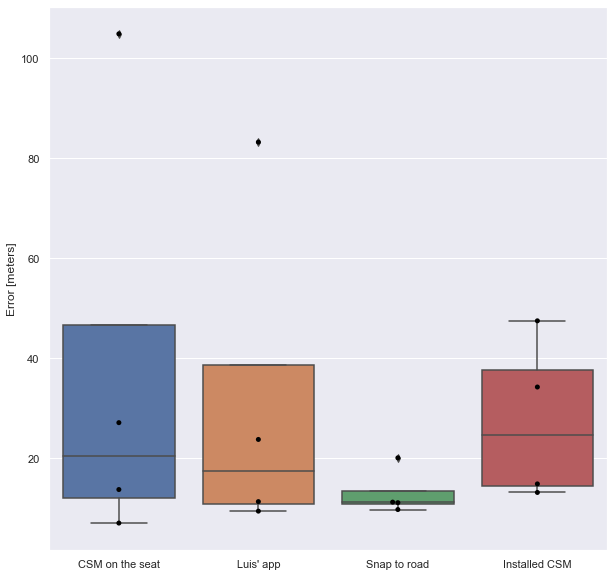

In [10]:
# plot the errors vs label
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.boxplot(y="error", x="label", data=error, showfliers=True)
sns.swarmplot(x="label", y="error", data=error, color="#000000")
ax.set(xlabel='', ylabel='Error [meters]')
